In [120]:
import torch
import torch.nn as nn
import os
from scripts.models.autoencoder_cnn import CNNAutoencoder
from torch.utils.data import Dataset, DataLoader
from scripts.dataset_template import DatasetTemplate
import numpy as np
import matplotlib.pyplot as plt

In [121]:
#check if cuda available

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [122]:
#paths
path_data_main = "Data_abs_only"

data_train_path = f"/home/bolci/Documents/Projekty/5G_OPEN_RAN/Anomaly_detection/5G_Open_RAN/{path_data_main}/Data_channels/train/comeretial"
data_test_folder_path = f"/home/bolci/Documents/Projekty/5G_OPEN_RAN/Anomaly_detection/5G_Open_RAN/{path_data_main}/Data_channels/test"
data_valid_folder_path = f"/home/bolci/Documents/Projekty/5G_OPEN_RAN/Anomaly_detection/5G_Open_RAN/{path_data_main}/Data_channels/valid"

testing_folders = os.listdir(data_test_folder_path)
valid_folders = os.listdir(data_valid_folder_path)

In [123]:
batch_size = 1

In [124]:
all_folders[0]

'results_batch-size=16_learning-rate=1e-05'

In [125]:
valid_datasets = {}
valid_dataloaders = {}
        
for valid_folder_name in valid_folders:
    valid_folder_path_all = os.path.join(data_valid_folder_path, valid_folder_name)
    valid_datasets[valid_folder_name] = DatasetTemplate(valid_folder_path_all, 1)
    valid_dataloaders[valid_folder_name] = DataLoader(valid_datasets[valid_folder_name], batch_size=batch_size, shuffle=True)

#test
test_datasets = {}
test_dataloaders = {}

for test_folder_name in testing_folders:
    test_folder_path_all = os.path.join(data_test_folder_path, test_folder_name)
    test_datasets[test_folder_name] = DatasetTemplate(test_folder_path_all, 1)
    test_dataloaders[test_folder_name] = DataLoader(test_datasets[test_folder_name], batch_size=batch_size, shuffle=True)


In [126]:
def valid_data(data_loader, model, loss):
    losses = []
    with torch.no_grad():
        for x,y in data_loader:
            pred = model(x.to(device))
            test_loss = loss(pred, y.to(device)).item()

            losses.append(test_loss)

    return np.asarray(losses)


def check_threshold(data_loader_true, data_loader_false, model, criteria, threshols_range = range(1,30), koeficient = 0.001):
    losses_true = valid_data(data_loader_true, model, criteria)
    losses_false = valid_data(data_loader_false, model, criteria)

    
    no_samples_true = len(losses_true)
    no_samples_false = len(losses_false)
    print(no_samples_true)
    print(no_samples_false)

    thresholds = []
    all_accuracy_false = []
    all_accuracy_true = []
    all_accuracy_all = []

    for single_threshold in threshols_range:
        threshold_all = single_threshold*koeficient

        all_true = np.where(losses_true > threshold_all)
        all_false = np.where(losses_false < threshold_all)

        no_true = len(all_true[0])
        no_false = len(all_false[0])
        

        accuracy_true = (no_true)/no_samples_true
        accuracy_false = (no_false)/no_samples_false
        accuracy_all = (no_true + no_false)/(no_samples_true + no_samples_false)
        
        thresholds.append(threshold_all)
        all_accuracy_true.append(accuracy_true)
        all_accuracy_false.append(accuracy_false)
        all_accuracy_all.append(accuracy_all)

    return thresholds, all_accuracy_true, all_accuracy_false, all_accuracy_all



In [128]:
path = '/home/bolci/Documents/Projekty/5G_OPEN_RAN/Anomaly_detection/5G_Open_RAN/scripts/Results_norm/'

800
888


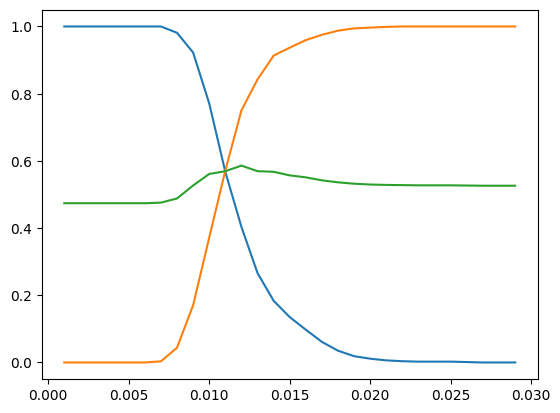

In [130]:
for single_folder in all_folders:
    single_path_full = os.path.join(path, single_folder, 'model.pt')

    model = CNNAutoencoder().to(device)
    model.load_state_dict(torch.load(single_path_full, weights_only=True))
    model.eval()
    criterion = nn.MSELoss()
    loss_RMS = lambda x,y: torch.sqrt(criterion(x, y))
    
    measured_threshold = check_threshold(valid_dataloaders['Fake_Bts_PCI_466'], valid_dataloaders['Fake_Bts_PCI_466_wPA'], model, loss_RMS)

    plt.figure()
    plt.plot(measured_threshold[0], measured_threshold[1])
    plt.plot(measured_threshold[0], measured_threshold[2])
    plt.plot(measured_threshold[0], measured_threshold[3])
    break

    

In [49]:
valid_dataloaders

{'Fake_Bts_PCI_466_wPA': <torch.utils.data.dataloader.DataLoader at 0x7b3b53eea260>,
 'Fake_Bts_PCI_466': <torch.utils.data.dataloader.DataLoader at 0x7b3b53fa9d50>}